# Stroke Prediction using Logistic Regression and K-Nearest Neighbors

### Importing Libraries

In [34]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

**Helpful Function for Later**

In [35]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show(block=True)

## 1. Data Overview/Preprocessing
### 1.1 Data Analysis
Before getting started, we need to know what the data looks like. If there are any null values, or values that can be simplified, or columns that are not needed for the task we are doing.

In [36]:
data = pd.read_csv("stroke.csv")
df = data.copy()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [38]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [39]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Count of 0 is much larger than 1 in this dataset, this is something we need to address later

In [40]:
for col in df.columns:
    count = df[col].nunique()
    print(col)
    if count > 10:
        print(df[col].describe())
    else:
        print(df[col].value_counts())
    print('\n')

id
count     5110.000000
mean     36517.829354
std      21161.721625
min         67.000000
25%      17741.250000
50%      36932.000000
75%      54682.000000
max      72940.000000
Name: id, dtype: float64


gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


age
count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64


hypertension
0    4612
1     498
Name: hypertension, dtype: int64


heart_disease
0    4834
1     276
Name: heart_disease, dtype: int64


ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64


work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


avg_glucose_level
count    5110.000000
mean      106.147677
std        

In [41]:
df[(df['work_type'] == 'Never_worked') | (df['gender'] == 'Other')]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0
1462,41870,Male,17.0,0,0,No,Never_worked,Rural,61.01,32.5,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
1922,51935,Male,16.0,0,0,No,Never_worked,Urban,59.99,28.2,never smoked,0
2346,61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
2721,23508,Female,17.0,0,0,No,Never_worked,Rural,88.57,31.1,never smoked,0


There are some null rows for BMI, for a cleaner analysis we'll remove these rows

work_type: Never worked -> never_worked only has a small representation of work_type and all rows with this category have no stroke, so it may not be relevant to our analysis

gender: Other -> appears only once, so we will remove this too

In [42]:
df.dropna(inplace=True)
df = df[~((df['work_type'] == 'Never_worked') | (df['gender'] == 'Other'))]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### 1.2 Data Visualization
Now lets visualize the data, check for high correlations, and possible key insights.

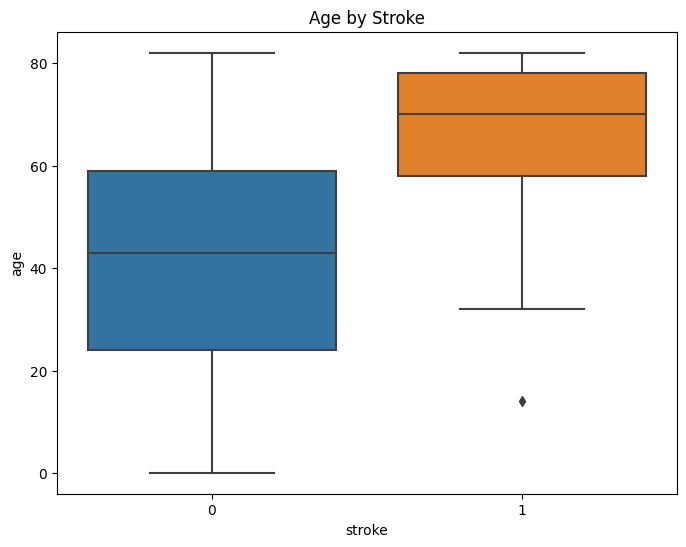

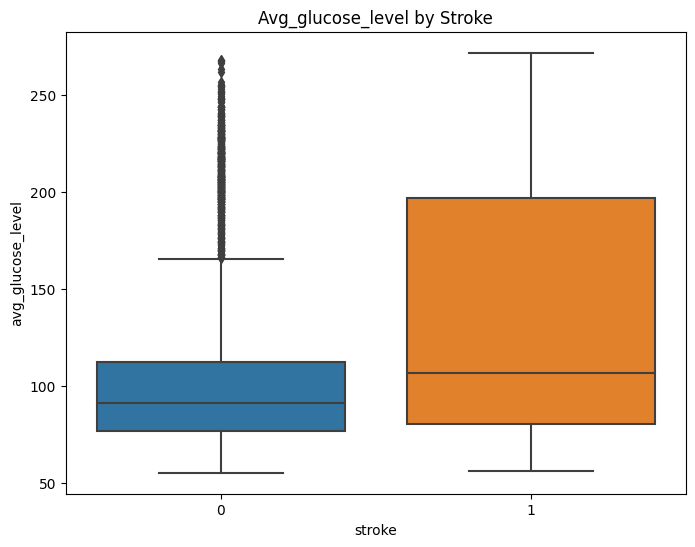

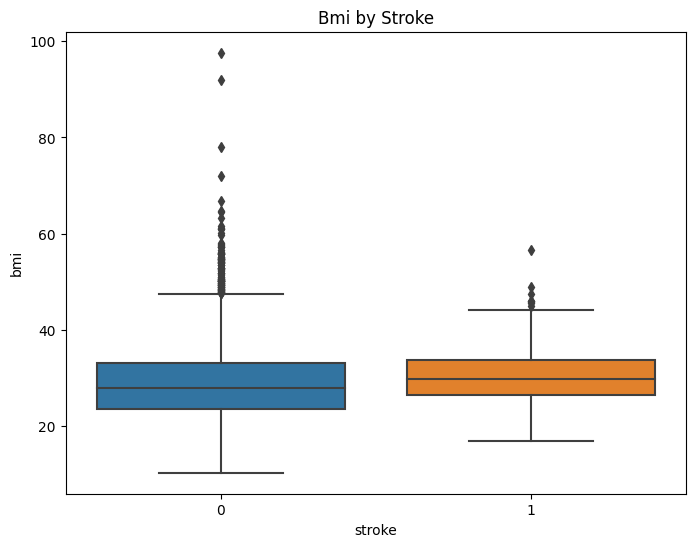

In [43]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

numberFeatures = ['age', 'avg_glucose_level', 'bmi']
for feature in numberFeatures:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='stroke', y=feature, data=df)
    plt.title(f'{feature.capitalize()} by Stroke')
    #plt.ylim(0, 45)
    plt.show()

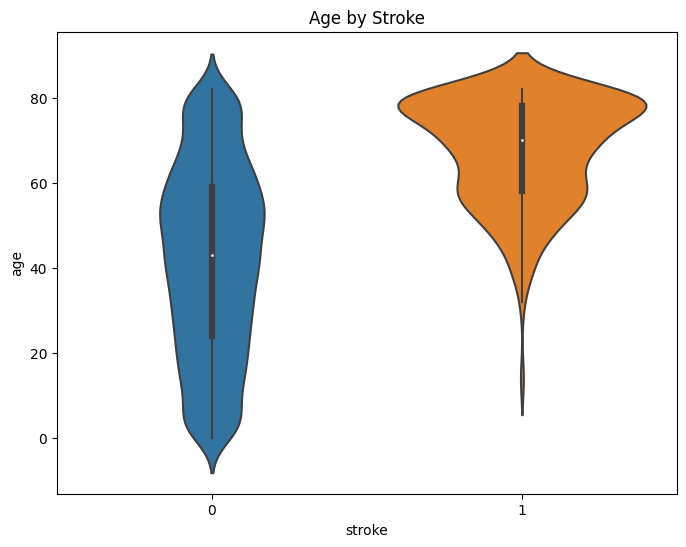

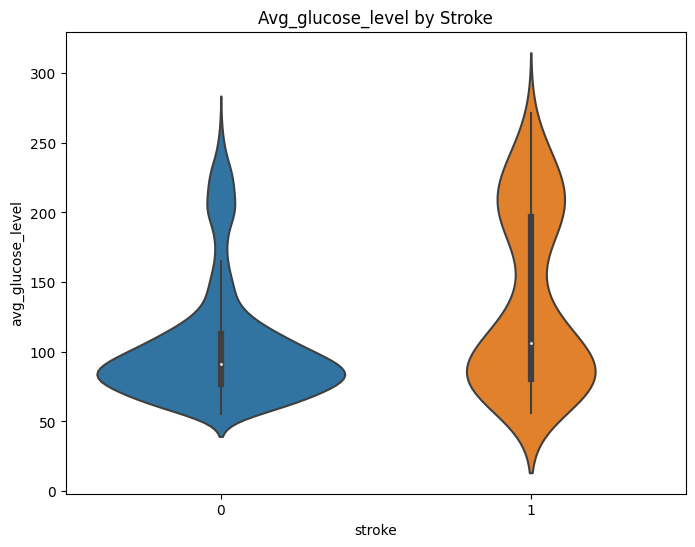

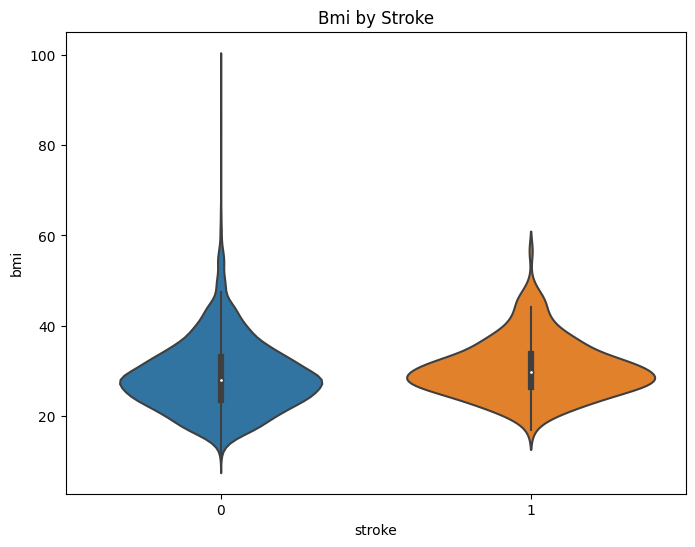

In [44]:
for feature in numberFeatures:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='stroke', y=feature, data=df)
    plt.title(f'{feature.capitalize()} by Stroke')
    plt.show()

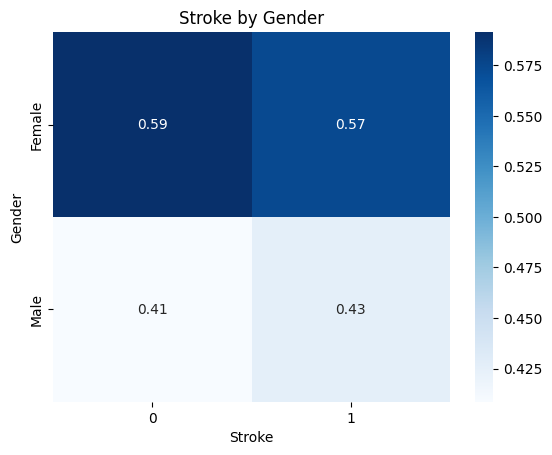

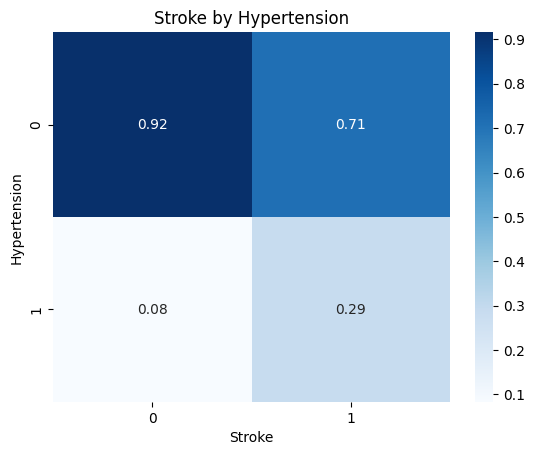

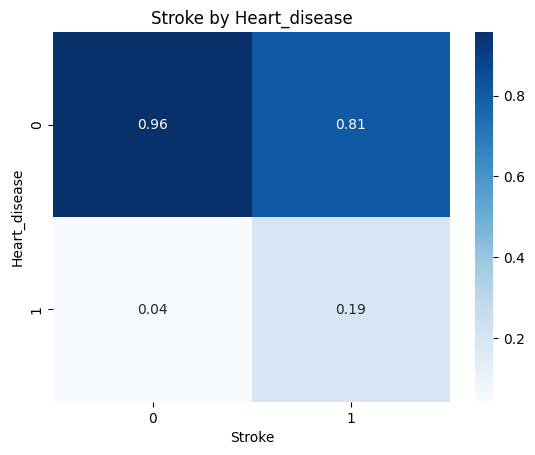

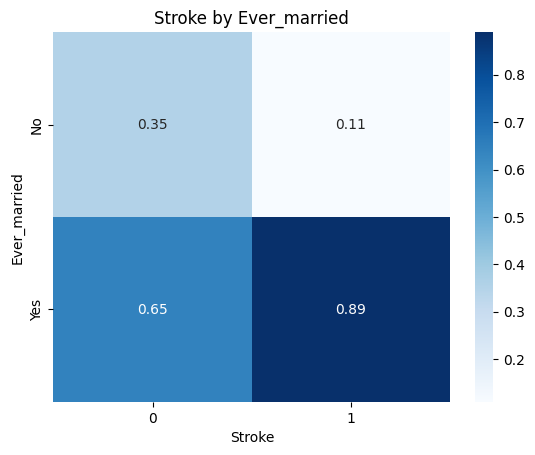

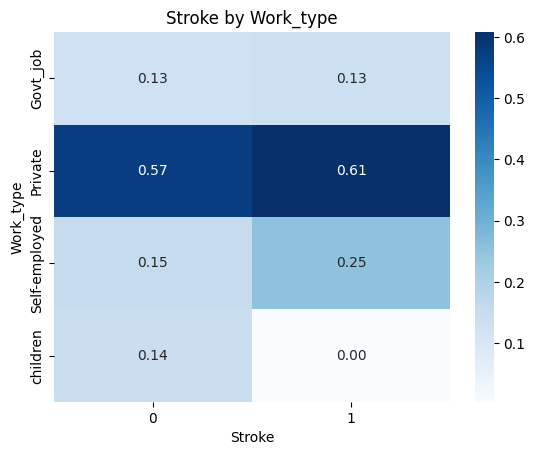

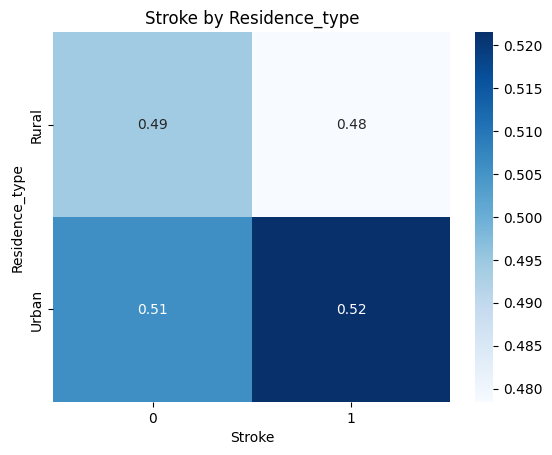

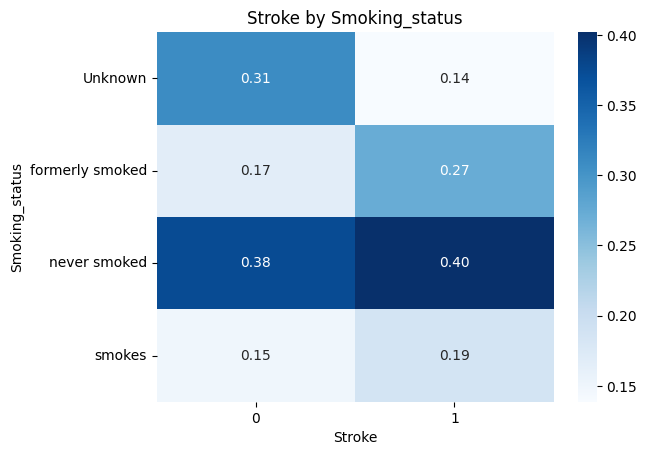

In [45]:
enumFeatures = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in enumFeatures:
    counts = df.groupby([feature, 'stroke']).size().unstack()
    # normalize because the number of 0 and 1 in the dataset is not balanced
    counts_norm = counts.div(counts.sum(axis=0), axis=1) 
    
    sns.heatmap(counts_norm, annot=True, cmap='Blues', fmt='.2f')
    
    # Set the title, x-axis label, y-axis label, and legend
    plt.title('Stroke by ' + feature.capitalize())
    plt.xlabel('Stroke')
    plt.ylabel(feature.capitalize())
    # Show the plot
    plt.show()

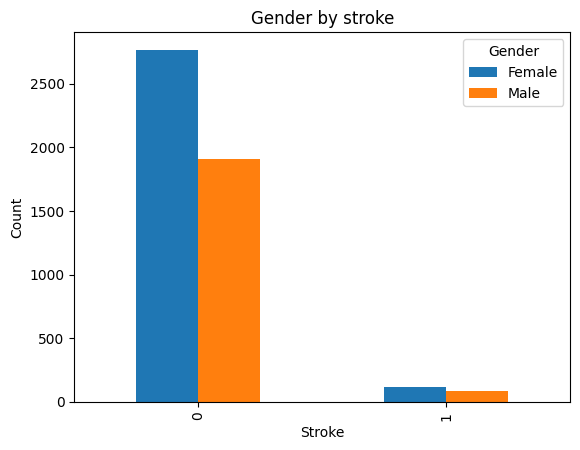

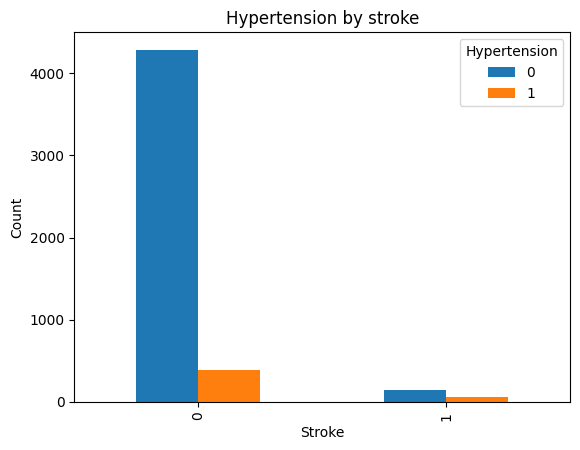

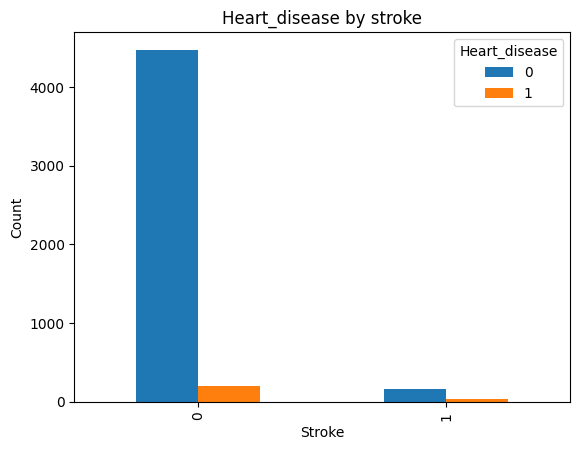

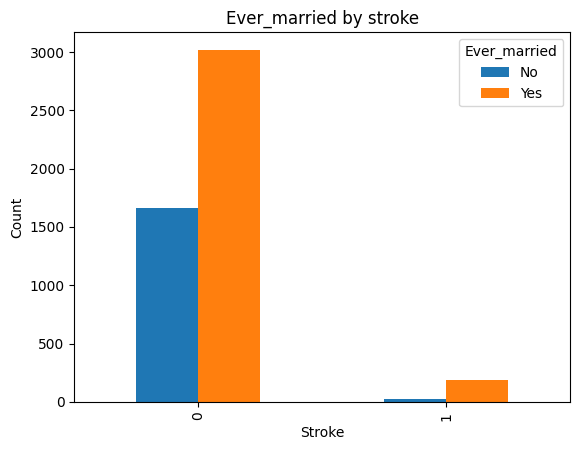

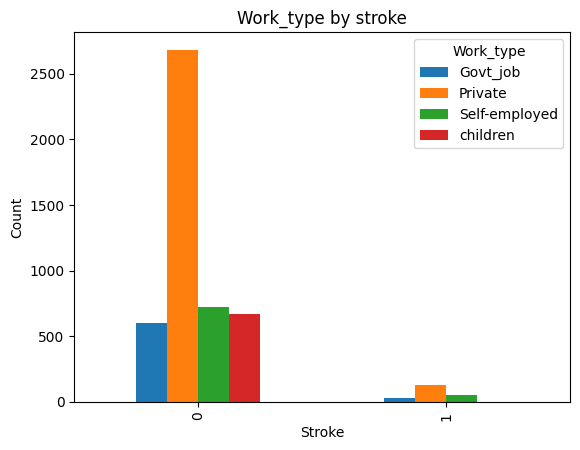

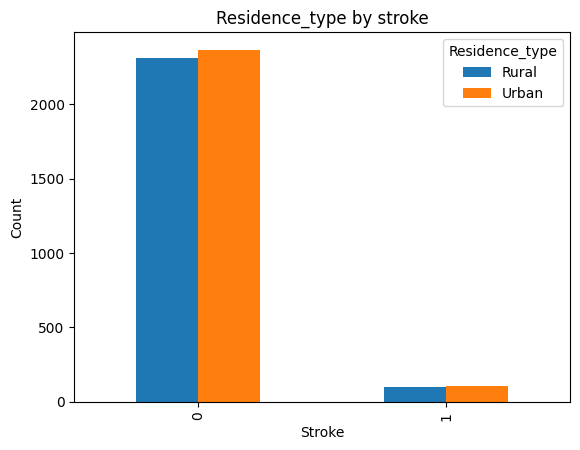

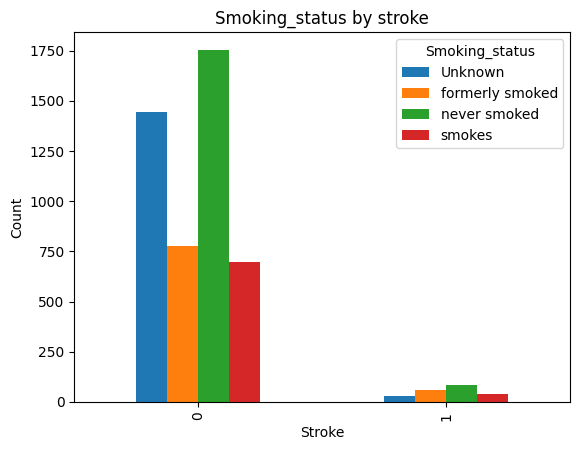

In [46]:
for feature in enumFeatures:
    counts = df.groupby(['stroke', feature]).size().unstack()
    counts.plot(kind='bar', stacked=False)
    
    # Set the title, x-axis label, y-axis label, and legend
    plt.title(feature.capitalize() + ' by stroke')
    plt.xlabel('Stroke')
    plt.ylabel('Count')
    plt.legend(title=feature.capitalize(), bbox_to_anchor=(1.0, 1.0))

    # Show the plot
    plt.show()

### 1.3 Categorizing Data to Labels
Some data would be easier to understand if we categorize them, such as BMI status and age range.

In [47]:
df['bmi_category'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_categogy'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_category'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

In [48]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,age_categogy,glucose_category
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obesity,Elderly,High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obesity,Elderly,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obesity,Mid Adults,High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Ideal,Elderly,High
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,Overweight,Elderly,High


### 1.4 Transforming non-number types to numbers
This is a good practice that'll help our algorithm later, especially for techniques such as Logistic Regression
#### 1.4.1 - Dynamic Code to change data to binaries

In [49]:
for col in df.columns:
    if df[col].dtype not in [int, float] and df[col].nunique() == 2:
        labelencoder = LabelEncoder()
        df[col] = labelencoder.fit_transform(df[col])

cat_cols = [col for col in df.columns if 2 < df[col].nunique() <= 10]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#### 1.4.2 Displaying the Results
As seen, data that only has two responses are turned binary (ex. 'Yes' or 'No' questions to 1s and 0s), while categorical questions (> 2 responses) were split into binaries (ex. BMI Type Overweight is now 1s (true) and 0s (false))  

In [50]:
for col in df.columns:
    count = df[col].nunique()
    print(col)
    if count > 10:
        print(df[col].describe())
    else:
        print(df[col].value_counts())
    print('\n')
df.columns

id
count     4886.000000
mean     37054.957429
std      21000.951500
min         77.000000
25%      18600.250000
50%      37615.000000
75%      55139.500000
max      72940.000000
Name: id, dtype: float64


gender
0    2886
1    2000
Name: gender, dtype: int64


age
count    4886.000000
mean       42.988973
std        22.534968
min         0.080000
25%        25.000000
50%        45.000000
75%        60.000000
max        82.000000
Name: age, dtype: float64


hypertension
0    4435
1     451
Name: hypertension, dtype: int64


heart_disease
0    4643
1     243
Name: heart_disease, dtype: int64


ever_married
1    3204
0    1682
Name: ever_married, dtype: int64


Residence_type
1    2475
0    2411
Name: Residence_type, dtype: int64


avg_glucose_level
count    4886.000000
mean      105.339073
std        44.481347
min        55.120000
25%        77.062500
50%        91.680000
75%       113.545000
max       271.740000
Name: avg_glucose_level, dtype: float64


bmi
count    4886.000000
mean   

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_category_Ideal',
       'bmi_category_Overweight', 'bmi_category_Obesity', 'age_categogy_Teens',
       'age_categogy_Adults', 'age_categogy_Mid Adults',
       'age_categogy_Elderly', 'glucose_category_Normal',
       'glucose_category_High', 'glucose_category_Very High'],
      dtype='object')

In [51]:
features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_category_Ideal',
       'bmi_category_Overweight', 'bmi_category_Obesity', 'age_categogy_Teens',
       'age_categogy_Adults', 'age_categogy_Mid Adults',
       'age_categogy_Elderly', 'glucose_category_Normal',
       'glucose_category_High', 'glucose_category_Very High']
X = df[features].to_numpy()
y = df['stroke'].to_numpy()
X

array([[1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 1.5 Expanding Minorities with SMOTE
Having an **imbalanced data distribution**, like how the number of stroke patients we have are much smaller in our dataset can be a problem in machine learning as the computer might only learn from the majority of examples. 

Standard ML techniques such as Decision Tree and Logistic Regression have a bias towards the majority class, and they tend to ignore the minority class.

Using SMOTE (Synthetic Minority Oversampling Technique) can make a machine learning model better at recognizing the minority examples and improve its overall performance. However, it's important to use SMOTE carefully and test the model on new data to make sure it's not just memorizing the training data.

#### 1.5.1 Before SMOTE

In [52]:
# Before SMOTE
X_train,X_test, y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=100)

print("Before SMOTE")
print("Counts of label '1': {}".format(sum(y_train == 1)))
print("Counts of label '0': {} \n".format(sum(y_train == 0)))

print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)
print()

Before SMOTE
Counts of label '1': 136
Counts of label '0': 3039 

X_train dataset:  (3175, 21)
y_train dataset:  (3175,)
X_test dataset:  (1711, 21)
y_test dataset:  (1711,)



We will have a hard time training this data as it is very imbalanced, in fact as it is right now, training this with linear regression will fail

#### 1.5.2 After SMOTE

In [53]:

# After SMOTE
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(X,y)
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.35,random_state=100)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.35, random_state=100)

sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("After SMOTE")
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

print("X_valid dataset: ", X_valid.shape)
print("y_valid dataset: ", y_valid.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)
print()

After SMOTE
After OverSampling, counts of label '1': 3031
After OverSampling, counts of label '0': 3049
X_valid dataset:  (2128, 21)
y_valid dataset:  (2128,)
X_test dataset:  (1146, 21)
y_test dataset:  (1146,)



As seen here, SMOTE oversamples the minority instances in our dataset and made it near equal to the majority class, making the data fit for machine learning

## 2. Machine Learning Algorithms
### 2.1 Logistic Regression
This type of machine learning fits our data, that is binary and categorical by nature. The goal of logistic regression is to find the relationship between variables and probability of an outcome. 

In [54]:
log_model = LogisticRegression(penalty=None)

In [55]:
log_model.fit(X=X_train, y=y_train)

LogisticRegression(penalty=None)

In [56]:
y_pred = log_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       561
           1       0.79      0.86      0.82       585

    accuracy                           0.81      1146
   macro avg       0.81      0.81      0.81      1146
weighted avg       0.81      0.81      0.81      1146



### 2.2 Evaluating Linear Regression Performance
#### 2.2.1 Confusion Matrix 
A confusion matrix displays the number of true positives, false positives, true negatives, and false negatives predicted by the model. This information is useful in evaluating the performance of the model, particularly in terms of its ability to accurately predict positive cases (true positives) and negative cases (true negatives).

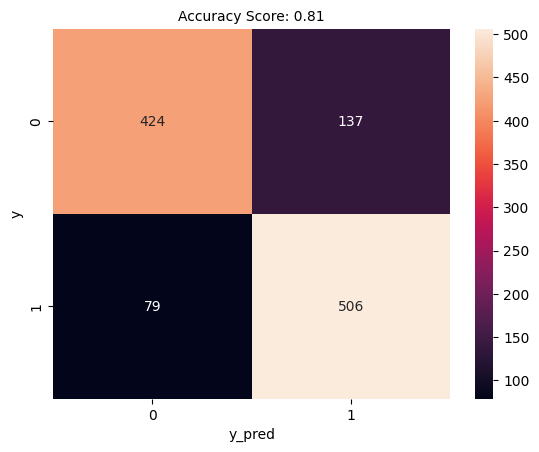

In [57]:
plot_confusion_matrix(y_test, y_pred)

#### 2.2.2 10 fold cross-validation
10-fold cross-validation is a good technique for evaluating a logistic regression model because it helps to reduce overfitting, uses all the available data, provides more stable estimates, and is computationally efficient.

In [58]:
cv_results = cross_validate(log_model,
                            X_train, y_train,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
for i in cv_results:
    print(str(i) + ':\t\t', cv_results[i].mean())

fit_time:		 0.015818119049072266
score_time:		 0.004188370704650879
test_accuracy:		 0.8133223684210528
test_precision:		 0.7796062272682603
test_recall:		 0.8723249956574606
test_f1:		 0.823224066653211
test_roc_auc:		 0.891219619089828


### 2.3 K-Nearest Neighbors (KNN)
KNN is a non-parametric and instance-based algorithm, which means that it does not make any assumptions about the underlying distribution of the data and instead relies on the proximity of training instances to make predictions for new instances.
#### 2.3.1 K-Nearest Neighbors without SMOTE

In [59]:
knn_model = KNeighborsClassifier().fit(X, y)

In [60]:
y_pred = knn_model.predict(X)
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4677
           1       0.59      0.05      0.09       209

    accuracy                           0.96      4886
   macro avg       0.77      0.52      0.53      4886
weighted avg       0.94      0.96      0.94      4886



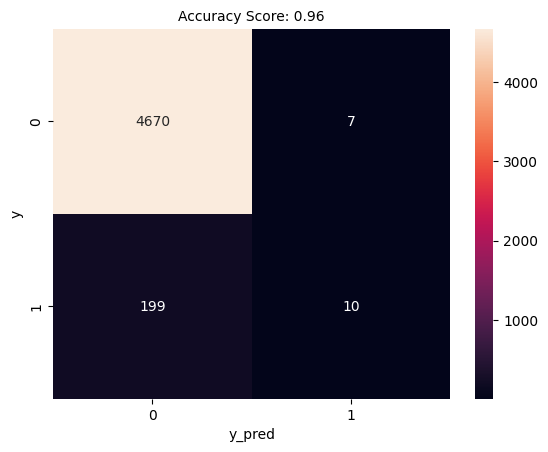

In [61]:
plot_confusion_matrix(y, y_pred)

here, the model is heavily biased towards having no stroke and has a very low recall for 1

In [62]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### 2.3.2 Hyper parameter optimization using oversampled strokes (KNN with SMOTE)

In [63]:
n_neighbors = GridSearchCV(knn_model, {"n_neighbors": range(2, 50)},
                           cv=5, n_jobs=-1, verbose=1).fit(x_smote, y_smote).best_params_
n_neighbors

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 4}

In [64]:
knn_model = knn_model.set_params(**n_neighbors).fit(x_smote, y_smote)
y_pred = knn_model.predict(x_smote)
print(classification_report(y_smote,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4677
           1       0.91      0.95      0.93      4677

    accuracy                           0.92      9354
   macro avg       0.93      0.92      0.92      9354
weighted avg       0.93      0.92      0.92      9354



### 2.4 Evaluating N-Nearest Neighbor Performance
#### 2.4.1 Confusion Matrix
The confusion matrix is a useful evaluation metric for a KNN model, just like in linear regression, because it provides insight into model performance, helps diagnose issues, is useful for optimizing model parameters, enables trade-off analysis, and provides a visual representation of the model's performance.

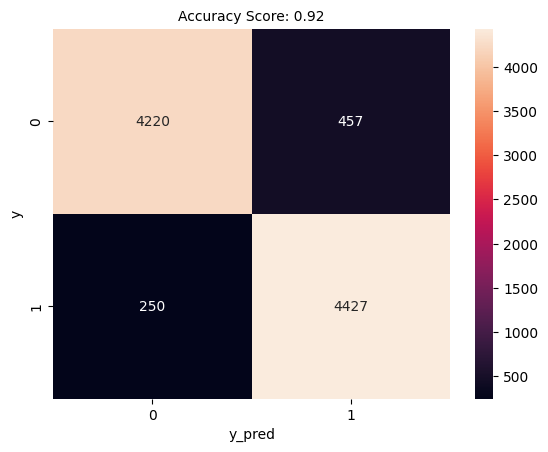

In [65]:
plot_confusion_matrix(y_smote, y_pred)

#### 2.4.2 10 fold cross-validation
Like for linear regression, 10-fold cross-validation is a good technique for evaluating a KNN model because it helps to reduce overfitting, provides a more accurate estimate of performance, improves stability, handles imbalanced data, and makes efficient use of the data.

In [66]:
cv_results = cross_validate(knn_model,
                            x_smote, y_smote,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
                            )
for i in cv_results:
    print(str(i) + ':\t\t', cv_results[i].mean())

fit_time:		 0.0005953311920166016
score_time:		 0.21539769172668458
test_accuracy:		 0.890638854609443
test_precision:		 0.8714992414467186
test_recall:		 0.9166186240597375
test_f1:		 0.8932639952398957
test_roc_auc:		 0.9388202370399152


## 3. Summary
This project aimed to predict how likely an individual is to have a stroke based on health and lifestyle factors. After exploring the data and cleaning it up, removing null values and irrelevant data, it was found that there is a significant class imbalance in the dataset, which might affect the machine learning results. SMOTE, a method that randomly increases minority classes, was used to oversample the minority. The dataset was then split into a 65:35 training and testing ratio, respectively. Logistic regression and K-nearest neighbor were then applied to the fixed data. Confusion matrices and cross-validation techniques were then used to evaluate performance and accuracy. After comparing the results, we found that KNN had better results overall.